# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

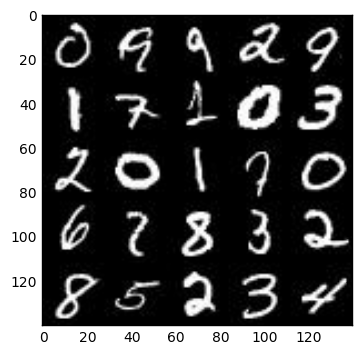

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

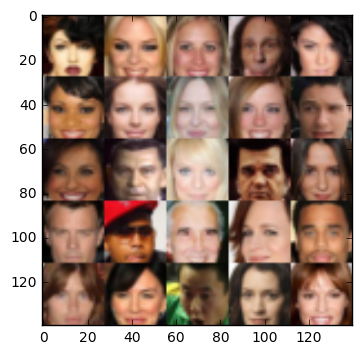

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Implement Function
    image_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='image_real')
    Z_input = tf.placeholder(tf.float32, [None, z_dim], name='Z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return image_real, Z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*channels
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # Now is 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now is 4x4x512
        
        # Flatten
        #flatten = tf.contrib.layers.flatten(relu2)
        flatten = tf.reshape(relu3, (-1, 4*4*512))
        
        # Fully connected layer
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape
        x2 = tf.reshape(x1, [-1, 7, 7, 512])
        #x2 = tf.contrib.layers.flatten(x2)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x512
        
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now is 14x14x256
        
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha*bn4, bn4)
        # Now is 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        # Now is 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function
    smooth = 0.1
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                        labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                   labels=tf.ones_like(d_logits_fake)))
    
                                 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

Notice how the train operations are wrapped in a with tf.control_dependencies block so the batch normalization layers can **update** their population statistics.

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #Get the trainable variables, split them into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Training operation
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

**Notice when we call `generator` to create the samples to display, we set `training` to `False`**. **That's so the batch normalization layers will use the population statistics rather than the batch statistics**. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    #return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. **Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches**.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    
    #saver = tf.train.Saver()
    losses = []
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                # Multiply 2 change from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images*2
                
                #Sample radom noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer, The generator doesn't actually use input_real in g_train_opt
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print loss every 10 batches
                if steps % 10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append([train_loss_d, train_loss_g])
                 
                # Print samples every 100 batches
                if steps % 100==0:
                    show_generator_output(sess, 9, input_z, image_channels, data_image_mode)
                    # samples.append(gen_samples)
        #saver.save(sess, './checkpoints/generator.ckpt')
     
    #     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 40.1771
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 35.1613
Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 25.4207
Epoch 1/2... Discriminator Loss: 2.5010... Generator Loss: 0.1874
Epoch 1/2... Discriminator Loss: 3.0110... Generator Loss: 0.2882
Epoch 1/2... Discriminator Loss: 2.2305... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.6378
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.5439... Generator Loss: 0.8761


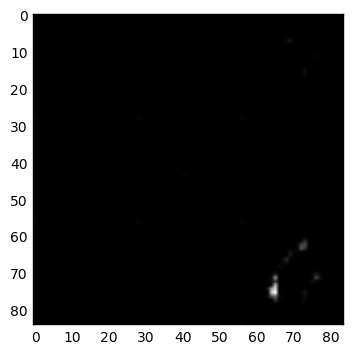

Epoch 1/2... Discriminator Loss: 2.1987... Generator Loss: 0.2228
Epoch 1/2... Discriminator Loss: 1.7421... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.7578... Generator Loss: 0.3821
Epoch 1/2... Discriminator Loss: 1.6659... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.8318


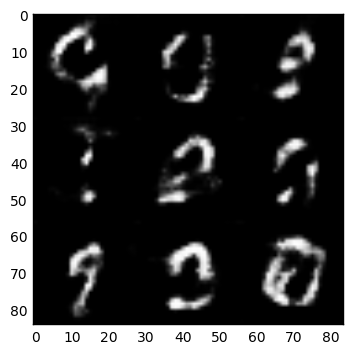

Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.7034... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 0.3272
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.6155... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.6093


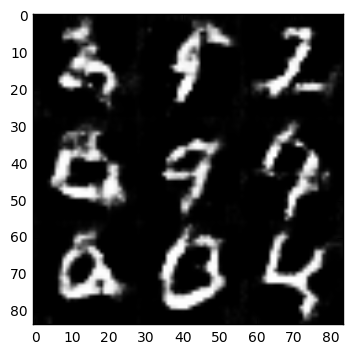

Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.4925
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.9009... Generator Loss: 0.2901
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7803
Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.4114


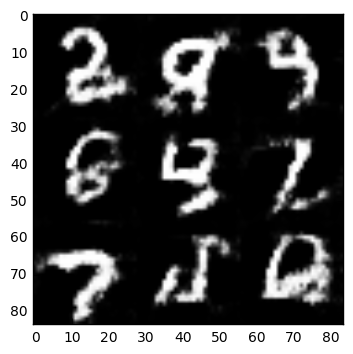

Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 1.6551... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.8646... Generator Loss: 1.5859
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 1.5536... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 1.6816... Generator Loss: 0.3605


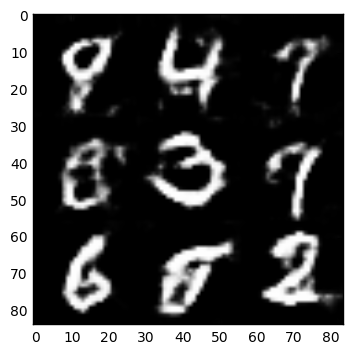

Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 1.1555
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.4229
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.5277
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.5558


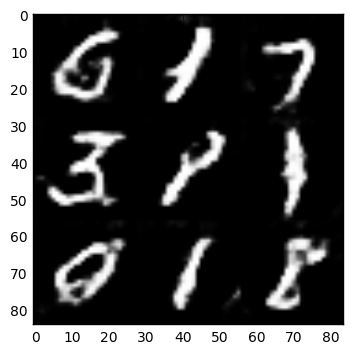

Epoch 1/2... Discriminator Loss: 1.9614... Generator Loss: 0.2579
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.9058... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 1.5321


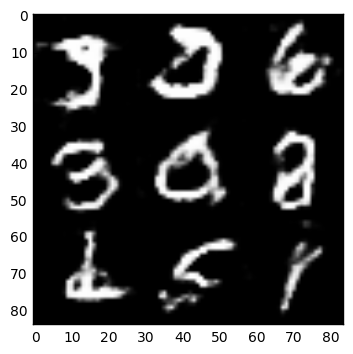

Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.8113... Generator Loss: 0.2901
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.6439... Generator Loss: 0.3814
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 1.1834


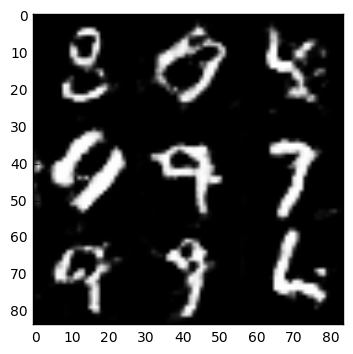

Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.7766... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 1.7953... Generator Loss: 0.3517
Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 1.6020
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.5724


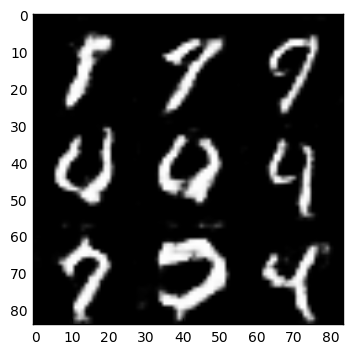

Epoch 1/2... Discriminator Loss: 1.6250... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 2.0022... Generator Loss: 1.9949


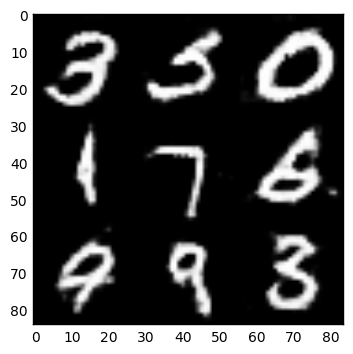

Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 2.1392... Generator Loss: 0.2208
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.4726


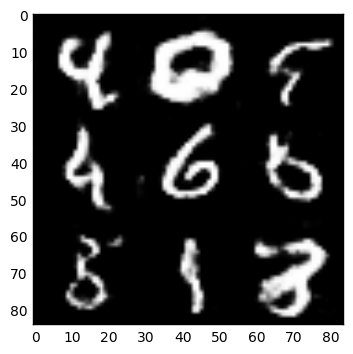

Epoch 2/2... Discriminator Loss: 1.5546... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 1.6782... Generator Loss: 1.2771
Epoch 2/2... Discriminator Loss: 2.0225... Generator Loss: 0.2497
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5959
Epoch 2/2... Discriminator Loss: 1.5351... Generator Loss: 0.4329
Epoch 2/2... Discriminator Loss: 1.5653... Generator Loss: 1.6074
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.5780
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7932


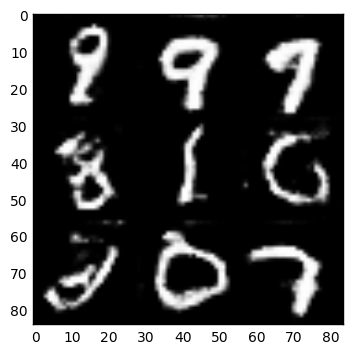

Epoch 2/2... Discriminator Loss: 1.8487... Generator Loss: 0.2976
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.7793... Generator Loss: 0.3504
Epoch 2/2... Discriminator Loss: 1.7609... Generator Loss: 1.8475
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 1.5603... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.5822... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.8210... Generator Loss: 0.3294
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.4766


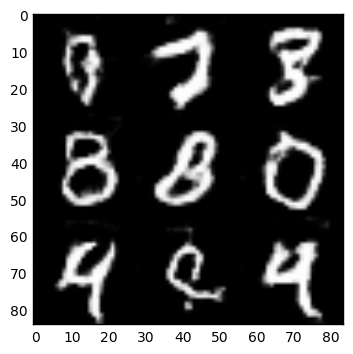

Epoch 2/2... Discriminator Loss: 1.5435... Generator Loss: 0.4539
Epoch 2/2... Discriminator Loss: 1.8570... Generator Loss: 2.1928
Epoch 2/2... Discriminator Loss: 1.6533... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 1.6401
Epoch 2/2... Discriminator Loss: 1.6609... Generator Loss: 1.4156
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.6168... Generator Loss: 0.4148
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 1.1161


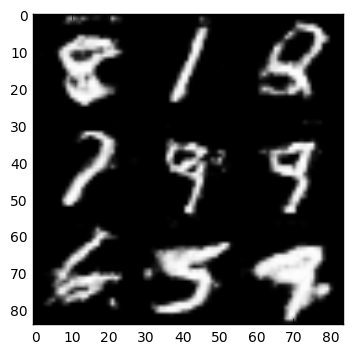

Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.9495... Generator Loss: 0.2840
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 1.2058
Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 1.7926... Generator Loss: 0.3497
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.7136... Generator Loss: 0.3393
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.7912... Generator Loss: 0.3041


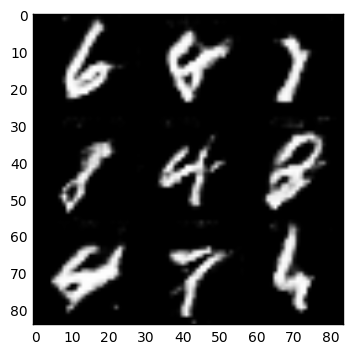

Epoch 2/2... Discriminator Loss: 2.0169... Generator Loss: 0.3054
Epoch 2/2... Discriminator Loss: 1.8924... Generator Loss: 0.2956
Epoch 2/2... Discriminator Loss: 1.6066... Generator Loss: 1.8997
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 1.7199... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.8081... Generator Loss: 0.3212
Epoch 2/2... Discriminator Loss: 1.9643... Generator Loss: 1.7517
Epoch 2/2... Discriminator Loss: 1.5159... Generator Loss: 0.5029


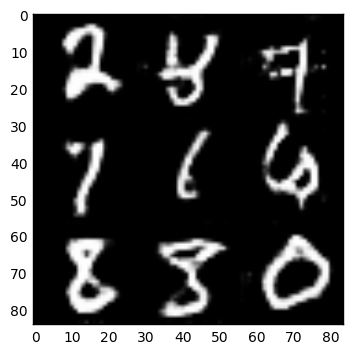

Epoch 2/2... Discriminator Loss: 1.7084... Generator Loss: 0.3807
Epoch 2/2... Discriminator Loss: 2.0150... Generator Loss: 2.4516
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.5813... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.0516
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 0.5571
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.7574... Generator Loss: 2.1684


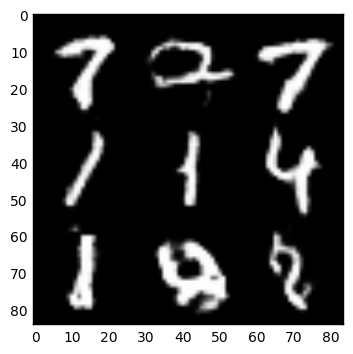

Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 1.7619... Generator Loss: 0.3589
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.7475... Generator Loss: 0.3376
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 2.1048... Generator Loss: 0.2514
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 0.8913


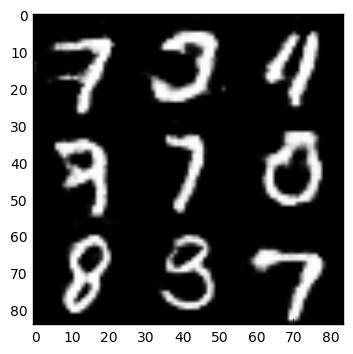

Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 2.0287... Generator Loss: 0.2386
Epoch 2/2... Discriminator Loss: 1.4843... Generator Loss: 0.4889
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.5218
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 1.5237
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 1.2739


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


# Avoid stacking memory
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

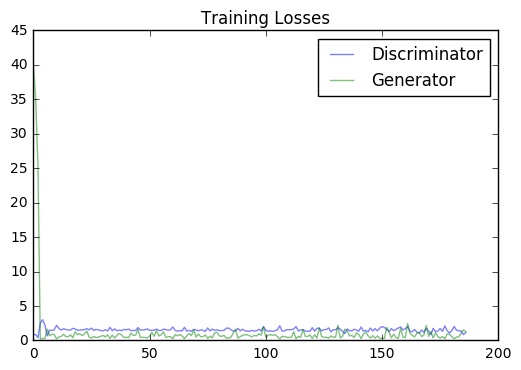

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Note
**I just scratch the results and shut down during the training process since it takes a long time to run. The results showed in the readme.md and demo folder based on my previous running results.**

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 12.7192
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 21.8431
Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 3.7403
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 2.5789
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 2.7232
Epoch 1/1... Discriminator Loss: 2.9151... Generator Loss: 0.1868


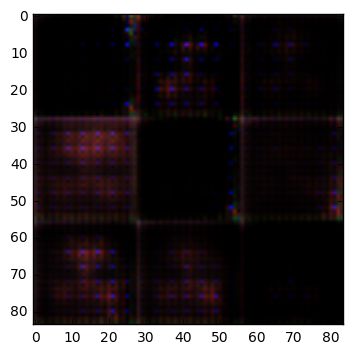

Epoch 1/1... Discriminator Loss: 1.9085... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 2.3844... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.9535... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.4753
Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 1.0164


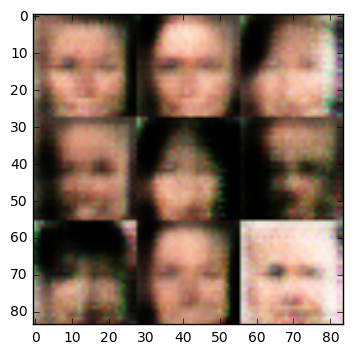

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 3.6173
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.5959
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 3.9712
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 1.1033


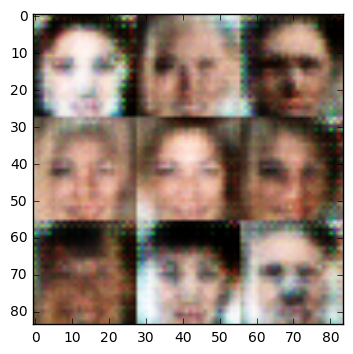

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.7929


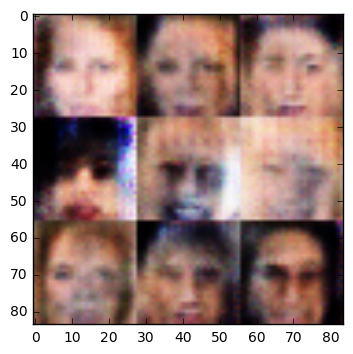

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7217


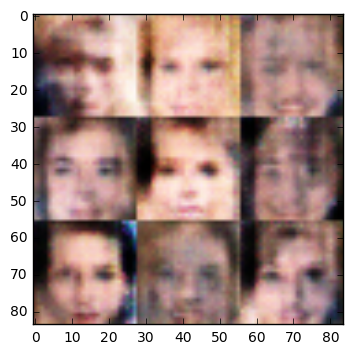

Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.9808


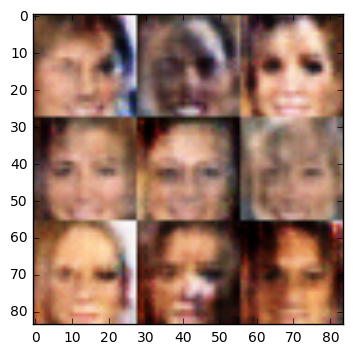

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.8068


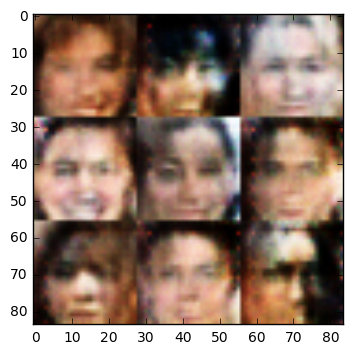

Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6373


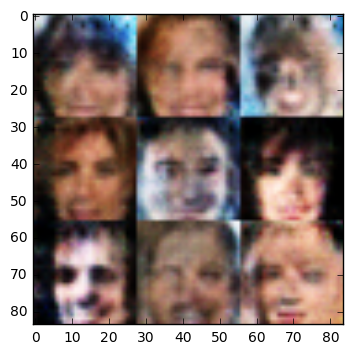

Epoch 1/1... Discriminator Loss: 1.7376... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6683


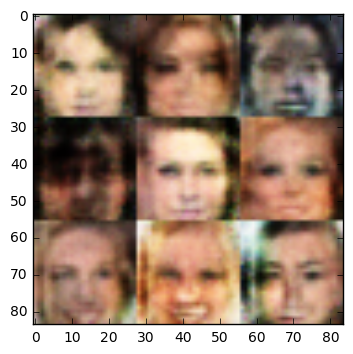

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7378


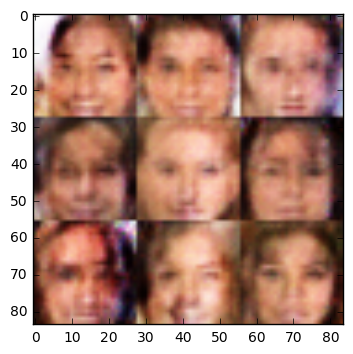

Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6869


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


# Avoid stacking memory
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    loss1 = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
loss1 = np.array(loss1)
plt.plot(loss1.T[0], label='Discriminator', alpha=0.5)
plt.plot(loss1.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.